In [30]:
import io
import urllib

import matplotlib.pyplot as plt
from PIL import Image, ImageOps
from tensorflow.keras.preprocessing import image

%config InlineBackend.figure_format='retina' 

def load_image_from_url(url, target_size=None, color_mode='rgb'):
    assert color_mode in ('grayscale', 'rgb'), 'color_mode must be "grayscale" or "rgb"'
    response = urllib.request.urlopen(url)
    img = Image.open(io.BytesIO(response.read()))
    img = img.convert('RGB')
    if color_mode == 'grayscale':
        img = ImageOps.grayscale(img)
    if target_size:
        img = img.resize(target_size, Image.NEAREST) # resize
    return image.img_to_array(img)

def load_image_from_path(image_path, target_size=None, color_mode='rgb'):
    pil_image = image.load_img(image_path, 
                               target_size=target_size,
                            color_mode=color_mode)
    return image.img_to_array(pil_image)

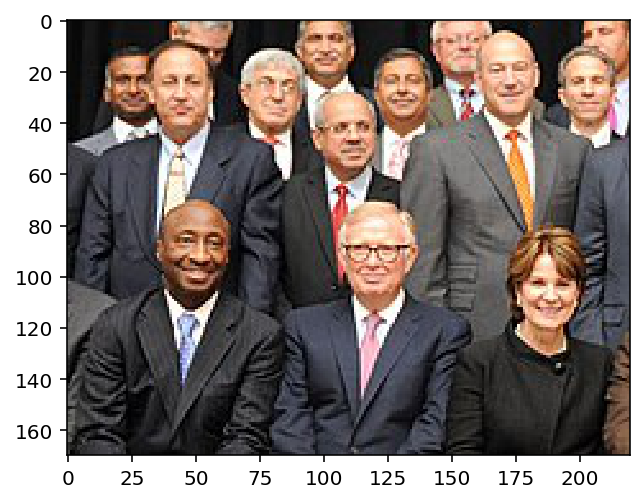

In [31]:
import numpy as np


Our_Image = r'C:\Users\pc\Desktop\MASTER COURSES\Block 2\Data Mining\Exams lab 2\Question 2\CEO\1.220px-group_of_fortune_500_ceos_in_2015__28cropped_to_remove_non-ceo_29.jpg'
color_image = load_image_from_path(Our_Image)

plt.imshow(color_image.astype(np.uint8))

In [12]:
import cv2
import numpy as np

import wget
model_url = 'https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml'
face_model = wget.download(model_url)
    
    
pre_image = load_image_from_path(Our_Image, color_mode='grayscale')
gray_image = np.squeeze(pre_image).astype('uint8')

face_classification = cv2.CascadeClassifier(face_model) # load the classifier 
faces = face_classification.detectMultiScale(gray_image, 1.3, 5) # detect the faces 
n_faces = len(faces) # get the number of faces
print('Detected {} faces!'.format(n_faces))

Detected 4 faces!


In [15]:
from tensorflow.keras.models import load_model

def apply_offsets(face_coordinates, offsets):
    """
    Derived from https://github.com/oarriaga/face_classification/blob/
    b861d21b0e76ca5514cdeb5b56a689b7318584f4/src/utils/inference.py#L21
    """
    x, y, width, height = face_coordinates
    x_off, y_off = offsets
    return (x - x_off, x + width + x_off, y - y_off, y + height + y_off)

gender_classifier = load_model('gender_mini_XCEPTION.21-0.95.hdf5') # load this only once! (not in a loop)

GENDER_OFFSETS = (10, 10)
INPUT_SHAPE_GENDER = gender_classifier.input_shape[1:3]

labels = ['woman', 'man']

for face_coordinates in faces: # using the output of the CascadeClassifier
    x1, x2, y1, y2 = apply_offsets(face_coordinates, GENDER_OFFSETS) # extends the bounding box
    face_img = gray_image[y1:y2, x1:x2] # only get the face 
    face_img = cv2.resize(face_img, (INPUT_SHAPE_GENDER)) # resize the image
    face_img = face_img.astype('float32') / 255.0 # preprocess the image
    face_img = np.expand_dims(face_img, 0) # batch of one
    probas = gender_classifier.predict(face_img) 
    print(labels[np.argmax(probas[0])], probas[0][np.argmax(probas[0])]) # print the class and the probabilitys

error: OpenCV(4.3.0) C:\projects\opencv-python\opencv\modules\imgproc\src\resize.cpp:3929: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'


In [14]:
emotion_classifier = load_model('fer2013_mini_XCEPTION.102-0.66.hdf5') # load this only once! (not in a loop)

EMOTION_OFFSETS = (0, 0)
INPUT_SHAPE_EMOTION = emotion_classifier.input_shape[1:3]

labels = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']

for face_coordinates in faces:
    x1, x2, y1, y2 = apply_offsets(face_coordinates, EMOTION_OFFSETS) 
    face_img = gray_image[y1:y2, x1:x2] # only get the face
    face_img = cv2.resize(face_img, (INPUT_SHAPE_EMOTION))
    face_img = face_img.astype('float32') / 255.0 # pre-processing 
    face_img = face_img - 0.5 # pre-processing specific to the emotion classifier
    face_img = face_img * 2.0 # pre-processing specific to the emotion classifier
    face_img = np.expand_dims(face_img, 0) # batch of one
    face_img = np.expand_dims(face_img, -1) # pre-processing specific to the emotion classifier
    probas = emotion_classifier.predict(face_img)
    label = labels[np.argmax(probas[0])]
    emotionprobas = dict(zip(labels, probas[0])) # make a dictionary from the labels and the probabilities
    print('This person looks {}'.format(label))
    print(emotionprobas)

This person looks happy
{'angry': 0.003823597, 'disgust': 2.0346379e-05, 'fear': 0.0066054617, 'happy': 0.93151504, 'sad': 0.011600782, 'surprise': 0.007516249, 'neutral': 0.03891857}
This person looks neutral
{'angry': 0.15689933, 'disgust': 0.00032454298, 'fear': 0.016465131, 'happy': 0.07419139, 'sad': 0.14954165, 'surprise': 0.021436146, 'neutral': 0.5811418}
This person looks sad
{'angry': 0.28928232, 'disgust': 0.0035668123, 'fear': 0.08970155, 'happy': 0.103181995, 'sad': 0.34636056, 'surprise': 0.0010898546, 'neutral': 0.16681683}
This person looks happy
{'angry': 0.010734766, 'disgust': 7.1040074e-07, 'fear': 0.007666039, 'happy': 0.8692425, 'sad': 0.009831236, 'surprise': 0.0032142685, 'neutral': 0.09931059}


In [16]:
!pip install git+https://github.com/Joeclinton1/google-images-download.git --upgrade

  Cloning https://github.com/Joeclinton1/google-images-download.git to c:\users\pc\appdata\local\temp\pip-req-build-rowqv3wp
  Created wheel for google-images-download: filename=google_images_download-2.8.0-py2.py3-none-any.whl size=15655 sha256=9beb3edb8400993b615e3b6fc7c380b07885aa3eb5ca28016e523a09b4088c2c
  Stored in directory: C:\Users\pc\AppData\Local\Temp\pip-ephem-wheel-cache-j88cj0km\wheels\79\5c\d2\2569a4f55ff29b3c4d6b1114d5110a70a79afbf381e6eb3e87
Successfully built google-images-download


  Running command git clone -q https://github.com/Joeclinton1/google-images-download.git 'C:\Users\pc\AppData\Local\Temp\pip-req-build-rowqv3wp'


In [18]:
MY_QUERY = "CEO"
N_IMAGES = 5
OUTPUT_DIR = r'C:\Users\pc\Desktop\MASTER COURSES\Block 2\Data Mining\Exams lab 2\Question 2\Land'

In [19]:
from google_images_download import google_images_download

response = google_images_download.googleimagesdownload() 
arguments = {"keywords": MY_QUERY,
             "limit": N_IMAGES, # 5 images
             "output_ todirectory":OUTPUT_DIR,
             "print_urls":True}   
paths = response.download(arguments) 


Item no.: 1 --> Item name = CEO
Evaluating...
Starting Download...
Image URL: https://upload.wikimedia.org/wikipedia/commons/thumb/4/4e/Group_of_Fortune_500_CEOs_in_2015_%28cropped_to_remove_non-CEO%29.jpg/220px-Group_of_Fortune_500_CEOs_in_2015_%28cropped_to_remove_non-CEO%29.jpg
Completed Image ====> 1.220px-group_of_fortune_500_ceos_in_2015_%28cropped_to_remove_non-ceo%29.jpg
Image URL: https://s3.amazonaws.com/utep-uploads/wp-content/uploads/sparkle-box/2019/04/30112737/Female-CEO.jpg
Completed Image ====> 2.female-ceo.jpg
Image URL: https://www.mckinsey.com/~/media/McKinsey/Business%20Functions/McKinsey%20Digital/Our%20Insights/The%20CEOs%20new%20technology%20agenda/CEO-standard-Offset300-1536x1536.jpg
Completed Image ====> 3.ceo-standard-offset300-1536x1536.jpg
Image URL: https://www.europeanceo.com/wp-content/uploads/2017/08/CEO-magic-touch.jpg
Completed Image ====> 4.ceo-magic-touch.jpg
Image URL: https://ceofluisteraar.com/wp-content/upload_folders/ceofluisteraar.com/CEO.jpg


In [29]:
paths[0]['CEO']

['C:\\Users\\pc\\Desktop\\MASTER COURSES\\Block 2\\Data Mining\\Exams lab 2\\Question 2\\downloads\\CEO\\1.220px-group_of_fortune_500_ceos_in_2015_%28cropped_to_remove_non-ceo%29.jpg',
 'C:\\Users\\pc\\Desktop\\MASTER COURSES\\Block 2\\Data Mining\\Exams lab 2\\Question 2\\downloads\\CEO\\2.female-ceo.jpg',
 'C:\\Users\\pc\\Desktop\\MASTER COURSES\\Block 2\\Data Mining\\Exams lab 2\\Question 2\\downloads\\CEO\\3.ceo-standard-offset300-1536x1536.jpg',
 'C:\\Users\\pc\\Desktop\\MASTER COURSES\\Block 2\\Data Mining\\Exams lab 2\\Question 2\\downloads\\CEO\\4.ceo-magic-touch.jpg',
 'C:\\Users\\pc\\Desktop\\MASTER COURSES\\Block 2\\Data Mining\\Exams lab 2\\Question 2\\downloads\\CEO\\5.ceo.jpg']

import pandas as pd
df = pd.DataFrame(paths, columns=["Path"])
df.head()